In [1]:
# https://www.kaggle.com/c/dog-breed-identification

path = '/notebook/kaggle/'
HOME_DIR = path + 'data/dogbreed/'
DATA_DIR = HOME_DIR # + 'sample/'
RESULTS_DIR = DATA_DIR + 'results/'
TRAIN_DIR = DATA_DIR + 'train/'
VAL_DIR = DATA_DIR + 'valid/'
TEST_DIR = DATA_DIR + 'test/'

In [2]:
!echo $CUDA_VISIBLE_DEVICES # Should be 0

0


In [3]:
!pip install scikit-image
!pip install kaggle-cli # Kaggle command-line interface

In [4]:
%matplotlib inline

# from __future__ import division,print_function

import os, json, glob, shutil
from skimage.transform import resize
from skimage.io import imsave, imread
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2, l1
from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

Using TensorFlow backend.


Set up kaggle config for this competition (after agreeing to rules).

In [5]:
with open(path+'kaggle.txt') as json_file:  
    kg_data = json.load(json_file)
    
username = kg_data['username']
password = kg_data['password']

!kg config -g -u $username -p $password -c 'dog-breed-identification'

#%cd $DATA_HOME_DIR
#!kg download

#!unzip -q sample_submission.csv.zip
#!unzip -q imgs.zip
#!unzip -q driver_imgs_list.csv.zip

### Data set-up

In [38]:
# Show number of files in training/validation directories
train_content = glob.glob(TRAIN_DIR+'/*/*.jpg') # Get list of image files
print('# of training images: '+str(len(train_content)))
val_content = glob.glob(VAL_DIR+'/*/*.jpg')
print('# of validation images: '+str(len(val_content)))
test_content = glob.glob(TEST_DIR+'/unknown/*.jpg')
print('# of test images: '+str(len(test_content)))

# of training images: 8178
# of validation images: 2044
# of test images: 10357


#### Enforce training/validation split - 
Show number of files in training/validation directories

In [10]:
train_class_folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))]) # Get all directories 
val_class_folders = ([name for name in os.listdir(VAL_DIR)
            if os.path.isdir(os.path.join(VAL_DIR, name))])

train_content_len = []
for folder in train_class_folders:
    contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
    train_content_len.append(len(contents))
    print(os.path.join(TRAIN_DIR,folder),str(len(contents))+' files')
    
val_content_len = []
for folder in val_class_folders:
    contents = os.listdir(os.path.join(VAL_DIR,folder)) # Get list of contents
    val_content_len.append(len(contents))
    print(os.path.join(VAL_DIR,folder),str(len(contents))+' files')

('/notebook/kaggle/data/dogbreed/train/miniature_schnauzer', '63 files')
('/notebook/kaggle/data/dogbreed/train/sealyham_terrier', '70 files')
('/notebook/kaggle/data/dogbreed/train/french_bulldog', '57 files')
('/notebook/kaggle/data/dogbreed/train/toy_poodle', '64 files')
('/notebook/kaggle/data/dogbreed/train/irish_wolfhound', '90 files')
('/notebook/kaggle/data/dogbreed/train/appenzeller', '68 files')
('/notebook/kaggle/data/dogbreed/train/bedlington_terrier', '71 files')
('/notebook/kaggle/data/dogbreed/train/lakeland_terrier', '81 files')
('/notebook/kaggle/data/dogbreed/train/saint_bernard', '65 files')
('/notebook/kaggle/data/dogbreed/train/labrador_retriever', '73 files')
('/notebook/kaggle/data/dogbreed/train/bouvier_des_flandres', '66 files')
('/notebook/kaggle/data/dogbreed/train/standard_schnauzer', '65 files')
('/notebook/kaggle/data/dogbreed/train/english_setter', '67 files')
('/notebook/kaggle/data/dogbreed/train/german_short-haired_pointer', '64 files')
('/notebook/kag

Split training and validation set such that a percentage of images in the validation set are not in the training set

In [11]:
validation_split = 0.2

# Check difference between number of files in training v. validation set
target_val_size = int((len(train_content)+len(val_content))*validation_split)
split_diff = target_val_size-len(val_content)

# Enforce train/validate split
if (split_diff>0):
    
    print('Moving '+str(split_diff)+' files')
    
    for file_name in train_content[:split_diff]:
        full_file_name = os.path.join(TRAIN_DIR, file_name)

        if (os.path.isfile(full_file_name)):
            #shutil.move(full_file_name, VAL_DIR)
            pass

Define model parameters

In [12]:
batch_size = 32
epoch_count = 5
input_shape = (256,256,3)
valid_steps = 75 # Validation steps
output_dim = len(train_class_folders) # n-way categorical classification task

Load ground truth from .csv file

In [15]:
train_data = pd.read_csv(os.path.join(DATA_DIR,'labels.csv'))
#train_data.loc[train_data['id'] == some_value]

Move files to appropriate category folder

In [16]:
def create_image_data(image_dir):

    images = glob.glob(image_dir+'*.jpg')

    print('Moving images...')
    for image_name in images:

        filename = os.path.basename(image_name)
        breed = (train_data.loc[train_data['id'] == filename[:-4]]['breed']).values[0]
        breed_dir = image_dir+breed
        if (not os.path.isdir(breed_dir)):
            os.mkdir(breed_dir)

        shutil.move(os.path.join(image_dir,image_name), breed_dir)
        #print(os.path.join(image_dir,filename), breed_dir)

    print('Finished moving images')

#create_image_data(TRAIN_DIR)
#create_image_data(VAL_DIR)

Plot examples of each class of input image (and save figure to .png)

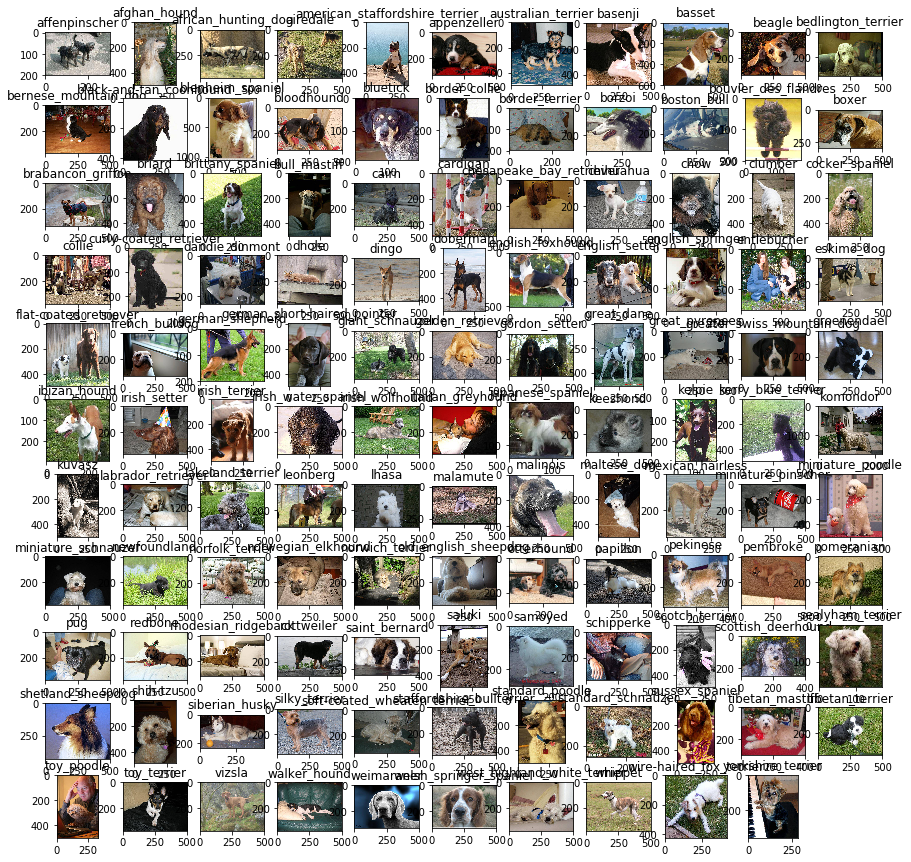

In [26]:
%matplotlib inline
from PIL import Image

fig = plt.figure(figsize=(15, 15)) # , dpi=150

path = TRAIN_DIR

row = col = int(np.ceil(np.sqrt(len(train_class_folders))))

for i,folder in enumerate(sorted(train_class_folders)):
    
    ax = fig.add_subplot(row, col, i+1) # Add sub-axes

    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    
    # Show image from each class 
    ax.set_title(folder)
    ax.imshow(Image.open(os.path.join(path,folder)+'/'+contents[0]))
    #ax.axis('off')
    
fig.savefig(RESULTS_DIR+'training_class_examples.png')


Use ImageDataGenerator to read images from directories

In [34]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.05, rotation_range=15,
                channel_shift_range=10, height_shift_range=0.03, width_shift_range=0.05)  
                #rotation_range=15, height_shift_range=0.05, 
                #shear_range=0.1, channel_shift_range=20, width_shift_range=0.1
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(     
    TRAIN_DIR,  # Target directory   
    shuffle=True,       
    target_size=input_shape[:-1],
    batch_size=batch_size,       
    class_mode='categorical'
    )
valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='categorical'
    )

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
('data batch shape:', (32, 256, 256, 3))
('labels batch shape:', (32, 120))


Plot images from generators just to make sure they're okay

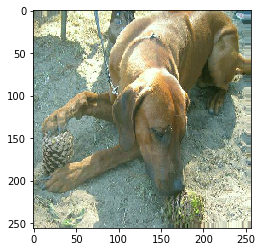

Actual class: rhodesian_ridgeback


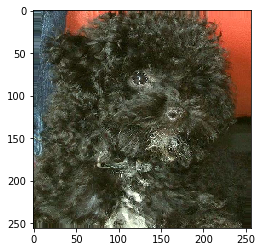

Actual class: toy_poodle


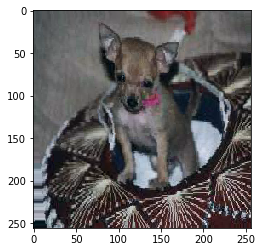

Actual class: chihuahua


In [29]:
# Test out image generator
for i in range(0, 3):
    inverted_dict = dict([[v,k] for k,v in train_generator.class_indices.items()])

    im_vals,class_val = train_generator.next()
    #predictions = pt_dr_conv_model.predict(im_vals)

    # Show image
    plt.imshow(im_vals[i])
    plt.show()

    y_test = np.argmax(class_val, axis=1)
    #y_pred = np.argmax(predictions, axis=1)

    # Show actual category
    category_val = inverted_dict[y_test[i]]
    print('Actual class: '+category_val)

    ## Show predicted category
    #class_preds = inverted_dict[y_pred[i]]
    #print('Predicted class: '+class_preds)

In [18]:
def plot_save_history(history, savename):
    fig = plt.figure()
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    
    ax = fig.add_subplot(2, 1, 1) # Add sub-axes
    ax.plot(epochs, acc, 'b')
    ax.plot(epochs, val_acc, 'bo')
    ax.set_title('Training and validation accuracy')
    
    ax = fig.add_subplot(2, 1, 2) # Add sub-axes
    ax.plot(epochs, loss, 'b')
    ax.plot(epochs, val_loss, 'bo')
    ax.set_title('Training and validation loss')
    plt.show()
    fig.savefig(savename) # , figsize=(5, 5), dpi=150

Submissions are evaluated on [Multi Class Log Loss](https://www.kaggle.com/wiki/MultiClassLogLoss) between the predicted probability and the observed target.

#### Create model
Instantiate the VGG16 convolutional base

In [19]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

#conv_base.trainable = False # Freeze the convolutional base

# Un-freeze the convolutional base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:        
        layer.trainable = False
        
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Pre-trained convolutional network with drop-out, partially un-frozen convolutional base

Compile model

In [22]:
from sklearn.metrics import log_loss
#score = log_loss(Y_valid, predictions_valid)
#print('Score log_loss: ', score)
    
pt_dr_conv_model = Sequential()
pt_dr_conv_model.add(conv_base)
pt_dr_conv_model.add(Flatten())
pt_dr_conv_model.add(Dropout(0.5)) # Add drop-out
pt_dr_conv_model.add(Dense(256, activation='relu'))
pt_dr_conv_model.add(Dense(output_dim,
                           activation='softmax',
                           kernel_regularizer=l2(0.01))) # activation='sigmoid'

pt_dr_conv_model.compile(optimizer=Adam(lr=1e-4), # RMSprop(lr=1e-3),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

Epoch 1/5
255/255 [==============================] - 135s - loss: 6.0261 - acc: 0.0471 - val_loss: 5.0966 - val_acc: 0.1536
Epoch 2/5
255/255 [==============================] - 131s - loss: 4.3649 - acc: 0.2523 - val_loss: 4.0845 - val_acc: 0.2734
Epoch 3/5
255/255 [==============================] - 131s - loss: 3.3054 - acc: 0.4323 - val_loss: 3.9542 - val_acc: 0.3319
Epoch 4/5
255/255 [==============================] - 131s - loss: 2.6101 - acc: 0.5729 - val_loss: 3.8826 - val_acc: 0.3539
Epoch 5/5
255/255 [==============================] - 131s - loss: 2.1065 - acc: 0.6854 - val_loss: 3.7991 - val_acc: 0.3318
Epoch 1/5
255/255 [==============================] - 136s - loss: 1.7415 - acc: 0.7668 - val_loss: 4.0612 - val_acc: 0.3591
Epoch 2/5
255/255 [==============================] - 131s - loss: 1.4889 - acc: 0.8268 - val_loss: 4.3965 - val_acc: 0.3506
Epoch 3/5
255/255 [==============================] - 131s - loss: 1.3225 - acc: 0.8667 - val_loss: 4.2892 - val_acc: 0.3548
Epoch 4/

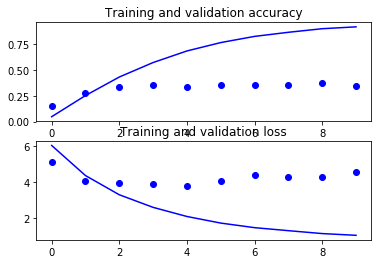

In [23]:
pt_dr_conv_model.optimizer.lr = 1e-4
history1 = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps
                   )
pt_dr_conv_model.optimizer.lr = 1e-5
history2 = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps
                   )

# Concatenate model histories together
vals = [history1.history[x]+history2.history[x] for x in history1.history.keys()]
big_hist = dict(zip(history1.history.keys(), vals))

# Save model weights
pt_dr_conv_model.save_weights(os.path.join(RESULTS_DIR,'dogbreed_pt_dr_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(big_hist, os.path.join(RESULTS_DIR, 'pt_dr_conv_model.png'))

# loss: 2.0790 - acc: 0.5174 - val_loss: 3.3365 - val_acc: 0.290

### Create .csv file for submission to Kaggle

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

-----
You must submit a csv file with the image file name, and a probability for each class.
The order of the rows does not matter. The file must have a header and should look like the following:

    img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
    img_0.jpg,1,0,0,0,0,...,0
    img_1.jpg,0.3,0.1,0.6,0,...,0
    ...

In [61]:
#!sudo apt-get install -y python-qt4

!pip install opencv-python
!apt update && apt install -y libsm6 libxext6 python-qt4

Ign:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
Ign:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:3 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release
Hit:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu xenial-security InRelease          
Hit:8 http://archive.ubuntu.com/ubuntu xenial InRelease                
Hit:9 http://archive.ubuntu.com/ubuntu xenial-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu xenial-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the n

Get:41 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libdrm-radeon1 amd64 2.4.76-1~ubuntu16.04.1 [21.6 kB]
Get:42 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libglapi-mesa amd64 17.0.7-0ubuntu0.16.04.2 [22.4 kB]
Get:43 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libllvm4.0 amd64 1:4.0-1ubuntu1~16.04.2 [12.2 MB]
Get:44 http://archive.ubuntu.com/ubuntu xenial/main amd64 libsensors4 amd64 1:3.4.0-2 [28.4 kB]
Get:45 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgl1-mesa-dri amd64 17.0.7-0ubuntu0.16.04.2 [5216 kB]
Get:46 http://archive.ubuntu.com/ubuntu xenial/main amd64 libx11-xcb1 amd64 2:1.6.3-1ubuntu2 [8956 B]
Get:47 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxcb-dri2-0 amd64 1.11.1-1ubuntu1 [6882 B]
Get:48 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxcb-dri3-0 amd64 1.11.1-1ubuntu1 [5218 B]
Get:49 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxcb-glx0 amd64 1.11.1-1ubuntu1 [20.9 kB]
Get:50 http://ar

Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../libjbig0_2.1-3.1_amd64.deb ...
7Progress: [ 11%] [#######...................................................] 8Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libtxc-dxtn-s2tc0:amd64.
Preparing to unpack .../libtxc-dxtn-s2tc0_0~git20131104-1.1_amd64.deb ...
Unpacking libtxc-dxtn-s2tc0:amd64 (0~git20131104-1.1) ...
7Progress: [ 12%] [########..................................................] 8Selecting previously unselected package libcap-ng0:amd64.
Preparing to unpack .../libcap-ng0_0.7.7-1_amd64.deb ...
Unpacking libcap-ng0:amd64 (0.7.7-1) ...
7Progress: [ 13%] [########..................................................] 8Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../libdbus-1-3_1.10.6-1ubuntu3.3_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.6-1ubuntu3.3) ...
Selecting previously unselected package dbus.
Preparing to unpack .../db

7Progress: [ 34%] [####################......................................] 8Selecting previously unselected package libxcb-dri3-0:amd64.
Preparing to unpack .../libxcb-dri3-0_1.11.1-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri3-0:amd64 (1.11.1-1ubuntu1) ...
7Progress: [ 35%] [#####################.....................................] 8Selecting previously unselected package libxcb-glx0:amd64.
Preparing to unpack .../libxcb-glx0_1.11.1-1ubuntu1_amd64.deb ...
Unpacking libxcb-glx0:amd64 (1.11.1-1ubuntu1) ...
Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../libxcb-present0_1.11.1-1ubuntu1_amd64.deb ...
7Progress: [ 36%] [#####################.....................................] 8Unpacking libxcb-present0:amd64 (1.11.1-1ubuntu1) ...
Selecting previously unselected package libxcb-sync1:amd64.
Preparing to unpack .../libxcb-sync1_1.11.1-1ubuntu1_amd64.deb ...
Unpacking libxcb-sync1:amd64 (1.11.1-1ubuntu1) ...
7Progress: [ 37%] [#############

Selecting previously unselected package libqtwebkit4:amd64.
Preparing to unpack .../libqtwebkit4_2.3.2-0ubuntu11_amd64.deb ...
7Progress: [ 57%] [##################################........................] 8Unpacking libqtwebkit4:amd64 (2.3.2-0ubuntu11) ...
Selecting previously unselected package python-sip.
Preparing to unpack .../python-sip_4.17+dfsg-1build1_amd64.deb ...
Unpacking python-sip (4.17+dfsg-1build1) ...
7Progress: [ 58%] [##################################........................] 8Selecting previously unselected package python-qt4.
Preparing to unpack .../python-qt4_4.11.4+dfsg-1build4_amd64.deb ...
Unpacking python-qt4 (4.11.4+dfsg-1build4) ...
7Progress: [ 59%] [###################################.......................] 8Selecting previously unselected package qt-at-spi:amd64.
Preparing to unpack .../qt-at-spi_0.4.0-3_amd64.deb ...
Unpacking qt-at-spi:amd64 (0.4.0-3) ...
Processing triggers for libc-bin (2.23-0ubuntu7) ...
Processing triggers for systemd (229-4

7Progress: [ 90%] [#####################################################.....] 8Setting up libqt4-script:amd64 (4:4.8.7+dfsg-5ubuntu2) ...
Setting up libqt4-sql:amd64 (4:4.8.7+dfsg-5ubuntu2) ...
Setting up libqt4-xmlpatterns:amd64 (4:4.8.7+dfsg-5ubuntu2) ...
7Progress: [ 91%] [#####################################################.....] 8Setting up libtiff5:amd64 (4.0.6-1ubuntu0.2) ...
Setting up libxi6:amd64 (2:1.7.6-1) ...
7Progress: [ 92%] [######################################################....] 8Setting up libxrender1:amd64 (1:0.9.9-0ubuntu1) ...
Setting up libqt4-sql-mysql:amd64 (4:4.8.7+dfsg-5ubuntu2) ...
7Progress: [ 93%] [#######################################################...] 8Setting up libqt4-test:amd64 (4:4.8.7+dfsg-5ubuntu2) ...
Setting up libqtassistantclient4:amd64 (4.6.3-7) ...
7Progress: [ 94%] [#######################################################...] 8Setting up python-sip (4.17+dfsg-1build1) ...
Setting up libqt4-declarative:amd64 (4:4.8.7+dfsg-5u

In [60]:
import cv2
for f in test_content:
    img = cv2.imread('../input/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

ImportError: libXrender.so.1: cannot open shared object file: No such file or directory

In [47]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=input_shape[:-1],
    batch_size=1,
    class_mode='categorical'
    )

Found 10357 images belonging to 1 classes.


In [50]:
preds = pt_dr_conv_model.predict_generator(test_generator,
                                        steps = len(test_content),
                                        verbose = 1)

10357/10357 [==============================] - 122s   


In [49]:
print(len(test_content),preds.shape)

(10357, (10357, 120))


In [54]:
list_out = sorted(zip(test_content,np.clip(preds,0.05,0.95)))
list_out = [('id','label')]+list_out # add column labels

print(list_out[:15])

[('id', 'label'), ('/notebook/kaggle/data/dogbreed/test//unknown/000621fb3cbb32d8935728e48679680e.jpg', array([ 0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,

In [24]:
pt_dr_conv_model.predict_generator(test_datagen,
                                   steps = len(test_content)/batch_size)

input_ids = [int(x[len('unknown/'):-len('.jpg')]) for x in batches.filenames]
    
list_out = sorted(zip(test_content,np.clip(preds[:,1],0.05,0.95)))

list_out = [('id','label')]+list_out # add column labels

print(list_out[:15])

[('id', 'label'), (1, 0.94999999), (2, 0.94999999), (3, 0.94999999), (4, 0.94999999), (5, 0.050000001), (6, 0.050000001), (7, 0.050000001), (8, 0.050000001), (9, 0.050000001), (10, 0.050000001), (11, 0.050000001), (12, 0.94999999), (13, 0.050000001), (14, 0.050000001)]


In [25]:
import csv

with open("data/dogscats/kaggle/predictions.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(list_out)

In [26]:
! kg submit data/dogbreeds/kaggle/predictions.csv

Starting new HTTPS connection (1): www.kaggle.com

